<h1 style="font-family: Arial; font-weight: 900; color: magenta; text-align: center;">MODEL EVALUATION AND HYPERPARAMETER TUNING</h1><br>

<br/><div style="font-family: Arial; color: darkblue; font-size: 14px; font-weight: 600"><a id="toc"></a>
In this part 6:
    <p style="margin: 0 0 0 2rem; font-size: 16px; font-weight: 800">[1. Pipelines](#1)</p><br/>
    <p style="margin: 0 0 0 2rem; font-size: 16px; font-weight: 800">[2. $k$-fold cross-validation](#2)</p><br/>
    <p style="margin: 0 0 0 2rem; font-size: 16px; font-weight: 800">[3. Learning and validation curves](#3)</p>
        <p style="margin: 0 0 0 4rem">[3a. Learning curves](#3a)</p>
        <p style="margin: 0 0 0 4rem">[3b. Validation curves](#3b)</p><br/>
    <p style="margin: 0 0 0 2rem; font-size: 16px; font-weight: 800">[4. Grid search and randomized search](#4)</p>
        <p style="margin: 0 0 0 4rem">[4a. Grid search](#4a)</p>
        <p style="margin: 0 0 0 4rem">[4b. Randomized search](#4b)</p>
        <p style="margin: 0 0 0 4rem">[4c. Search with successive halving](#4c)</p><br/>
    <p style="margin: 0 0 0 2rem; font-size: 16px; font-weight: 800">[5. Different evaluation metrics](#5)</p>
        <p style="margin: 0 0 0 4rem">[5a. Confusion matrix](#5a)</p>
        <p style="margin: 0 0 0 4rem">[5b. Accuracy, error, recall and precision of a classification model](#5b)</p>
        <p style="margin: 0 0 0 4rem">[5c. The receiver operating characteristic (ROC)](#5c)</p>
        <p style="margin: 0 0 0 4rem">[5d. Scoring metrics for multiclass classification](#5d)</p><br/>
    <p style="margin: 0 0 0 2rem; font-size: 16px; font-weight: 800">[Appendix - Dealing with class imbalance](#Appendix)</p></div>

In [1]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt

# The datasets we will use
df = pd.read_csv('wdbc.data', header=None)

# Beautify code results using colors
from colorama import Fore, Back, Style
# define some strings for cleaner code
BB = Fore.BLUE + Style.BRIGHT
MB = Fore.MAGENTA + Style.BRIGHT
YB = Fore.YELLOW + Style.BRIGHT

# Beautify figures by rendering them in SVG quality instead of JPG
# (don't use this if you prefer lightweight notebooks)
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats("svg")
# we'll use the "cyberpunk" color map
cmap = plt.get_cmap("cool")

<a id="1"></a><br><br><br><div style="font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">
    <h4 style="margin: 0 0 .5rem 2rem; font-size: 18px; font-weight: 800"><font color='darkpink'>1. PIPELINES</font></h4>$\quad$
        In this chapter, we will be working with the Breast Cancer Wisconsin dataset, which contains 569 examples of malignant and benign tumor cells. The first two columns in the dataset store the unique ID numbers of the patients and the corresponding diagnoses (M = malignant, B = benign), respectively. Columns 3-32 contain 30 real-valued features that have been computed from digitized images of cell nuclei, which can be used to build a model to predict whether a tumor is benign or malignant.<br>$\quad$
        First, we download the dataset, then we split it into training and test sets (with $80\%$ into training). The initial labels are <font color='darkred'>B</font> and <font color='darkred'>M</font>, so we first use <font color='#cc33ff'>scikit-learn</font>'s <font color='#cc33ff'>LabelEncoder</font> to transform them into <font color='darkred'>$0$</font> and <font color='darkred'>$1$</font> respectively :

In [2]:
# reads the "wdbc.data" in the folder; this dataset has no header
df = pd.read_csv('wdbc.data', header=None)

from sklearn.preprocessing import LabelEncoder
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
print(YB + "B" + BB + " and " + YB + "M" + BB + " are now replaced by" + MB, 
      le.transform(["B"])[0], BB + "and" + MB, le.transform(["M"])[0], BB+ "respectively")

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1)
print(BB + "And the original dataset has been divided into a training and a test set, with an 80-20% split.")

B and M are now replaced by 0 and 1 respectively
And the original dataset has been divided into a training and a test set, with an 80-20% split.


<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        The learning algorithms we are going to use require input features on the same scale for optimal performance. Since the features in the Breast Cancer Wisconsin dataset are measured on various different scales, we first <font color='#cc33ff'>standardize</font> our training matrix (about <font color='#cc33ff'>standardization</font>, see part 4, "3b. Bringing features onto the same scale"). Then, we reduce our dataset from its initial $30$ dimensions to a lower $2$-dimensional subspace via <font color='#cc33ff'>principal component analysis</font> (<font color='#cc33ff'>PCA</font>, see part 5, "1. Principal component analysis"). Finally, we apply a <font color='#cc33ff'>logistic regression algorithm</font> (see part 3, "2. The logistic regression").<br>$\quad$
        In order to use our algorithm on the test set, we need to apply the same transformations to it. Rather than applying these transformations one after the other on the <font color='#cc33ff'>training set</font>, and then transforming our <font color='#cc33ff'>training set</font> accordingly, we can chain the three transformations by using <font color='#cc33ff'>make_pipeline</font> from <font color='#cc33ff'>scikit-learn</font>'s <font color='#cc33ff'>pipeline</font> module.<br>$\quad$
    <font color='#cc33ff'>make_pipeline</font> takes an arbitrary number of <font color='darkpink'>scikit-learn transformers</font> (objects that support the fit and transform methods), followed by a <font color='#cc33ff'>scikit-learn</font> estimator (that implements the fit and predict methods). In our example, we use two <font color='#cc33ff'>scikit-learn</font> transformers, <font color='#cc33ff'>StandardScaler</font> and <font color='#cc33ff'>PCA</font>, and a <font color='#cc33ff'>LogisticRegression</font> estimator as inputs to the <font color='#cc33ff'>make_pipeline</font> function. The result is called a (<font color='#cc33ff'>scikit-learn</font>) <font color=darkpink>pipeline</font>.<br>$\quad$
    We use our pipeline to compute the test accuracy of our model :

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression())
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
test_acc = pipe_lr.score(X_test, y_test)
print(BB + "Test accuracy :" + MB, round(test_acc, 3))

Test accuracy : 0.956


<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Let's represent the inner workings of a generic pipeline in a diagram :

<figure style="text-align: center;">
    <img src="6.1. Inner workings of a pipeline.png" alt="Figure showing the inner workings of a pipeline object. On the top-left, enters the training set with the associated labels; it is scaled; the scaled matrix is then reduced to a lower dimension; finally, an estimator is fitted on the reduced matrix. Once the estimator is fitted, enters the test set on the top-right; the same rescaling is applied to it, and the rescaled test set is then reduced using the transformer applied to the rescaled training set; finally, the model returns its predictions at the bottom right of the figure." width="350" />
    <figcaption style="margin-top: .5rem; font-weight: bold; color: purple">Inner workings of a pipeline</figcaption>
</figure>

<a id="2"></a><br><br><br><div style="font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">
    <h4 style="margin: 0 0 .5rem 2rem; font-size: 18px; font-weight: 800"><font color='darkpink'>2. $K$-FOLD CROSS-VALIDATION</font></h4>$\quad$
        Given a known dataset with enough instances, we often split the training data into two parts : a <font color='#cc33ff'>training set</font>, which is used to fit the different models, and a <font color='#cc33ff'>validation set</font>, which is used to test the different models (or various choices of hyperparameters for a given type of algorithm) and choose the best one. The <font color='#cc33ff'>training set</font> then gives a less biased estimate of the ability of the chosen algorithm to generalize to new data than if we used it to choose our model.<br>$\quad$
        A potential bias may occur when the number of instances is not large enough : the performance estimate may be very sensitive to how we partition the <font color='#cc33ff'>training set</font> into the training and the validation subsets. One way of alleviating this bias is to follow the <font color='darkpink'>cross-validation algorithm</font> : randomly split our <font color='#cc33ff'>training set</font> into a partition of <font color='#1aabff'>$k$</font> parts, called <font color='darkpink'>folds</font>. We then cycle around the folds, taking one apart as a <font color='#cc33ff'>validation set</font>, and uniting the other <font color='#1aabff'>$(k\!-\!1)$</font> folds to constitute the associated <font color='#cc33ff'>training set</font>; thus we get <font color='#1aabff'>$k$</font> tests and their performance estimates instead of $1$. Once we have found a satisfactory model (or satisfactory hyperparameter values), we can retrain the model on the complete <font color='#cc33ff'>training set</font> and obtain a final performance estimate using the independent test set.<br>$\quad$
        Note that larger values of <font color='#1aabff'>$k$</font> will increase the runtime of the cross-validation algorithm. A good standard value for <font color='#1aabff'>$k$</font> in <font color='#cc33ff'>$k$-fold cross-validation</font> is <font color='#1aabff'>$10$</font>, "as empirical evidence shows". For smaller datasets, a larger <font color='#1aabff'>$k$</font> may be used, up to <font color='#1aabff'>$k$ = $m$</font>. <font color='#1aabff'>$k$ = $m$</font> corresponds to using only one training example for validation during each iteration; this extreme case is called the <font color='darkpink'>leave-one-out cross-validation</font>; it is commonly used for very small datasets. For larger datasets, a smaller <font color='#1aabff'>$k$</font> may be used, eg <font color='#1aabff'>$k=5$</font>, which is the default value for <font color='#cc33ff'>scikit-learn</font> cross-validation methods.<br>$\quad$
        A slight improvement over the standard <font color='#cc33ff'>$k$-fold cross-validation</font> approach, when possible, is the <font color='darkpink'>stratified $k$-fold cross-validation</font>, where the folds preserve the class label proportions of the <font color='#cc33ff'>training set</font>, so that they are a better representation of the <font color='#cc33ff'>training set</font>. <font color='#cc33ff'>scikit-learn</font> uses this type of folds by default in the <font color='#cc33ff'>cross_val_score</font> method (from its <font color='#cc33ff'>model_selection</font> module), which yields the <font color='#1aabff'>$k$</font> scores obtained by the algorithm in the <font color='#1aabff'>$k$</font> tests that the method runs. By default, the scores are the results given by the estimator’s default scorer. For example, in our pipeline, the estimator is the <font color='#cc33ff'>LogisticRegression</font>; its default scorer returns the <font color='darkpink'>accuracy scores</font> (ie the ratio of correctly predicted instances to the total number of instances). Since these <font color='#1aabff'>$k$</font> tests are partially randomized (run over stratified folds randomly chosen), a mean of these <font color='#1aabff'>$k$</font> scores  is generally the most significant result we can get to estimate the quality of our algorithm before applying it to the <font color='#cc33ff'>test set</font>.<br>$\quad$
        As an example, let's see the accuracy scores returned by the <font color='#cc33ff'>cross_val_score</font> method and their <font color='#cc33ff'>mean</font> and <font color='#cc33ff'>standard deviation</font> for our <font color='#cc33ff'>pipeline</font> over the <font color='#cc33ff'>wdbc.data</font> dataset :

In [4]:
from sklearn.model_selection import cross_val_score
# 'cv' is the number of folds; 'n_jobs' is the number of cores used by the method
scores = cross_val_score(estimator=pipe_lr, X=X_train, y=y_train, cv=10, n_jobs=1)
print(BB + "The list of accuracy scores for our pipeline is\n" + MB, scores)
print(BB + "The mean of these accuracy scores is" + MB, f"{np.mean(scores)*100:.2f}%",
      BB + "and its standard deviation is" + MB, f"{np.std(scores):.3f}")

The list of accuracy scores for our pipeline is
 [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
The mean of these accuracy scores is 94.95% and its standard deviation is 0.014


<a id="3"></a><br><br><br><div style="font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">
    <h4 style="margin: 0 0 .5rem 2rem; font-size: 18px; font-weight: 800"><font color='darkpink'>3. LEARNING AND VALIDATION CURVES</font></h4>
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>3a. Learning curves</font><a id="3a"></a></p>$\quad$
        A model that is too complex for the <font color='#cc33ff'>training set</font> – eg a <font color='#cc33ff'>very deep decision tree</font> – tends to overfit the training data, and generalizes poorly to unseen data. Collecting more training instances, when possible, often helps reduce overfitting. We can assess the benefit of adding instances by plotting training and validation accuracies as functions of the number of samples used. These curves are called the <font color='darkpink'>learning curves</font> of our model.<br>$\quad$
        First, let's see the three main types of learning curves, and various ways to alleviate the corresponding problems, if any :

<figure style="text-align: center;">
    <img src="6.2. The three types of learning curves.png" alt="This diagram is divided into three figures, each representing one of the three typical learning curves. On each figure the x-axis represents the number of training samples, while the y-axis represents the training and validation accuracy scores; also, the desired accuracy is represented by a horizontal line. As the number of training samples increases, the model finds it harder to fit them all (especially when there are outliers), and the training accuracy decreases and converges towards some value when the number of instances is large; its generalization capabilities improves, though, so its validation accuracy improves. The top-left figure, titled 'High bias', represents the case of bad training accuracy scores when the number of samples is large; this means that the model (or some of its hyperparameters) cannot fit the training data (underfitting). The top-right figure, titled 'High variance', represents the case of training accuracies that remain excellent, but validation accuracies remain less than ideal; this means that the model fits the training data too closely (overfitting). And the bottom-right figure, titled 'Good bias-variance trade-off', shows training accuracies that decrease but stay above the desired accuracy, while the validation accuracies improve and converge towards the desired accuracy; these results are typical of a good model." width="350" />
    <figcaption style="margin-top: .5rem; font-weight: bold; color: purple">The three types of learning curves</figcaption>
</figure>

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
    The top-left figure represents a model with bad training accuracy scores; ie, the model underfits the training data. Common ways to address this issue are to increase the number of model parameters, or to increase the number of features, or to decrease the degree of regularization, if any (see part 3, "2g. Overfitting and regularized linear models").<br>$\quad$
    The upper-right figure shows a model that suffers from high variance, which is indicated by the large gap between the training and the cross-validation accuracy scores; ie, the model overfits the data. Common ways to address this issue are to collect more training data, or to reduce the complexity of the model, or to decrease the number of features via feature selection (see part 4, "4. Selecting meaningful features") or feature extraction (see part 5, "Dimensionality reduction"), or to increase the regularization parameter. Note that, while collecting more training data usually tends to decrease the chance of overfitting, it may not always help; for example, if the training data is extremely noisy or if the model is already very close to optimal.

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        With the next code, we plot the learning curves of a pipeline composed of a <font color='#cc33ff'>StandardScaler</font> (see part 3, "1b. Training the perceptron with scikit-learn") and a <font color='#cc33ff'>LogisticRegression</font> (see part 3, "2. The logistic regression", especially "2f. Logistic regression with scikit-learn") together with an <font color='#cc33ff'>$L^2$-regularization</font> (see part 3, "2g. Overfitting and regularized linear models") applied to the <font color='#cc33ff'>wdbc.data</font> dataset. We use the <font color='#cc33ff'>learning_curve(estimator, X, y, train_sizes=array([0.1, 0.33, 0.55, 0.78, 1.]), cv=None, n_jobs=None, shuffle=False, random_state=None)</font> function from the <font color='#cc33ff'>scikit-learn</font>'s <font color='#cc33ff'>model_selection</font> module, where I have selected the following parameters :<ul>
    <li><font color='#cc33ff'>estimator</font> : the algorithm under test</li>
    <li><font color='#cc33ff'>X</font> : the training matrix</li>
    <li><font color='#cc33ff'>y</font> : the training labels</li>
    <li><font color='#cc33ff'>train_sizes=array([0.1, 0.33, 0.55, 0.78, 1])</font> : an array specifying the sizes of the subsets of the <font color='#cc33ff'>training set</font> to use; it should be composed either of decimals, when the subset sizes are specified as proportions, or of integers, when the subset sizes are specified with exact numbers</li>
    <li><font color='#cc33ff'>cv=None</font> : the number of cross-validation folds - by default, <font color='#1aabff'>5</font> - ; by default, <font color='#cc33ff'>learning_curve</font> uses <font color='#cc33ff'>stratified $k$-fold cross-validation</font> in classification tasks (whether binary or multiclass)</li>
    <li><font color='#cc33ff'>n_jobs=None</font> : the number of CPU cores to use for parallel execution - <font color='#1aabff'>1</font> by default - ; <font color='#cc33ff'>n_jobs=</font>$\,$<font color='#1aabff'>-1</font> asks to use all available cores</li>
    <li><font color='#cc33ff'>shuffle=False</font> : by default, the training instances are taken from the dataset in their original order; this can be problematic, eg if the data is sorted by label; use <font color='#cc33ff'>shuffle=</font><font color='#1aabff'>True</font> to shuffle the data before selecting the subsets</li>
    <li><font color='#cc33ff'>random_state=None</font> : the seed used by the random number generator when <font color='#cc33ff'>shuffle=</font><font color='#1aabff'>True</font></li></ul><div style="margin-top: 20px"></div>$\quad$
        <font color='#cc33ff'>learning_curve</font> returns the following objects (see within the code how to collect the ones we are interested in) :<ul>
    <li><font color='#cc33ff'>train_sizes</font> : the <font color='#cc33ff'>train_sizes</font> argument provided when calling <font color='#cc33ff'>learning_curve</font>, or its default value</li>
    <li><font color='#cc33ff'>train_sizes_abs</font> : the list of integers corresponding to <font color='#cc33ff'>train_sizes</font> when <font color='#cc33ff'>train_sizes</font> was specified as proportions, otherwise <font color='#cc33ff'>train_sizes</font> itself)</li>
    <li><font color='#cc33ff'>train_scores</font> : the matrix where each row corresponds to a <font color='#cc33ff'>train_sizes_abs</font> value, each column corresponds to a <font color='#cc33ff'>cross-validation split</font>, and each entry is the <font color='#cc33ff'>training accuracy score</font> obtained for that specific train size and split</li>
    <li><font color='#cc33ff'>test_scores</font> : the same matrix, but where each entry is the <font color='#cc33ff'>validation accuracy score</font> obtained for that specific train size and split</li>
    <li><font color='#cc33ff'>fit_times</font> : the same matrix, but where each entry stores the total time taken to fit the model on that specific subset</li>
    <li><font color='#cc33ff'>score_times</font> : the same matrix, but where each entry stores the total time taken to evaluate the model on the validation fold</li></ul>

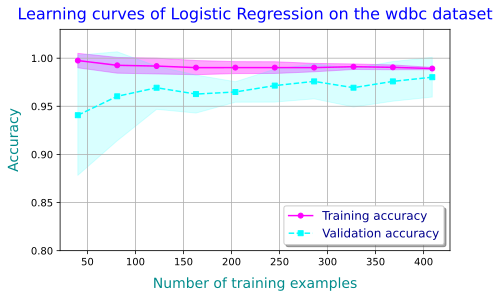

In [5]:
from sklearn.model_selection import learning_curve
# 'StandardScaler' standardizes the features by removing the mean and scaling to unit variance
# 'LogisticRegression' uses the l2 regularization with C=1 by default
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', max_iter=10000))
# 'np.linspace(0.1, 1, 10)' generates 10 equally spaced values from 0.1 to 1 (inclusive);
# although the data was already shuffled when we used 'train_test_split', it is good practice to
# shuffle it again, for robustness (according to ChatGPT)
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr, X=X_train, y=y_train,
                                            train_sizes=np.linspace(0.1, 1, 10), cv=10, shuffle=True,
                                            random_state=1, n_jobs=-1)
# the list of the means of each row (ie when we count all the columns - axis=1 -)
train_mean = np.mean(train_scores, axis=1)
# the list of the standard deviations along the rows
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.figure(figsize=(7, 4))
plt.title("Learning curves of Logistic Regression on the wdbc dataset", fontsize=16, color='blue', pad=10)
plt.plot(train_sizes, train_mean, marker='o', markersize=5, color=cmap(0.999), label="Training accuracy")
# 'plt.fill_between' fills the area between two curves, here in magenta with 35% opacity
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.35,
                 color=cmap(0.999))
plt.plot(train_sizes, test_mean, linestyle='--', marker='s', markersize=5, color=cmap(0),
         label="Validation accuracy")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15, color=cmap(0))
plt.grid()
plt.xlabel("Number of training examples", labelpad=10, fontsize=14, color='darkcyan')
plt.ylabel("Accuracy", labelpad=10, fontsize=14, color='darkcyan')
plt.legend(loc='lower right', fancybox=True, shadow=True, fontsize=12, labelcolor='darkblue')
plt.ylim([0.8, 1.03])
plt.show()

<br><br><div style="font-family: Arial; font-size: 14px; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>3b. Validation curves</font><a id="3b"></a></p>$\quad$
    While learning curves show the training and test accuracies as functions of the sample size, <font color='darkpink'>validation curves</font> show the training and test accuracies as functions of a hyperparameter that we want to optimize. For example, suppose that we want to optimize the inverse regularization parameter <font color='#cc33ff'>C</font> in our current model. We use the <font color='#cc33ff'>validation_curve(estimator, X, y, param_name, param_range, cv=None, n_jobs=None)</font> method from <font color='#cc33ff'>scikit-learn</font>'s <font color='#cc33ff'>model_selection</font> module, where I have selected the following parameters :<ul>
    <li><font color='#cc33ff'>estimator</font> : the algorithm family under test</li>
    <li><font color='#cc33ff'>$X$</font> : the training matrix</li>
    <li><font color='#cc33ff'>$y$</font> : the training labels</li>
    <li><font color='#cc33ff'>param_name</font> : the name of the hyperparameter that we want to optimize; the name must follow the following pattern :<br>$\quad$
    <font color='#5555ff'>$<\,$name of the method in the pipeline$\,>\;+\;$ '__' $\;$(dunder) $\;+\;<\,$name of the hyperparameter$\,>$</font> $\quad$ (eg $\;$<font color='#5555ff'>'logisticregression__C'</font>)</li>
    <li><font color='#cc33ff'>param_range</font> : the list of values that we want to test our hyperparameter with</li>
    <li><font color='#cc33ff'>cv=None</font> : the number of cross-validation folds - by default, <font color='#1aabff'>5</font> - ; by default, alike <font color='#cc33ff'>learning_curve</font>, <font color='#cc33ff'>validation_curve</font> uses <font color='#cc33ff'>stratified $k$-fold cross-validation</font> in classification tasks (whether binary or multiclass)</li>
    <li><font color='#cc33ff'>n_jobs=None</font> : the number of CPU cores to use for parallel execution - <font color='#1aabff'>1</font> by default - ; <font color='#cc33ff'>n_jobs=</font>$\,$<font color='#1aabff'>-1</font> asks to use all available cores</li></ul><div style="margin-top: 20px"></div>$\quad$
        <font color='#cc33ff'>validation_curve</font> returns the following objects :<ul>
    <li><font color='#cc33ff'>train_scores</font> : the matrix where each row corresponds to a <font color='#cc33ff'>param_range</font> value, each column corresponds to a <font color='#cc33ff'>cross-validation split</font>, and each entry is the <font color='#cc33ff'>training accuracy score</font> obtained for that specific hyperparameter value and split</li>
    <li><font color='#cc33ff'>test_scores</font> the same matrix, but where each entry is the <font color='#cc33ff'>validation accuracy score</font> obtained for that specific hyperparameter value and split</li></ul>

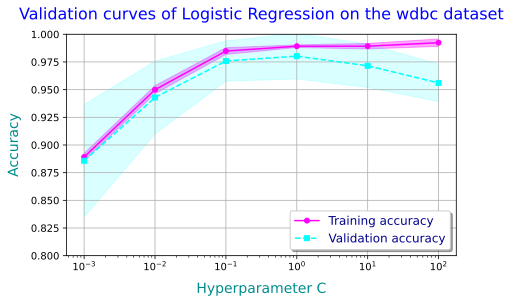

In [6]:
from sklearn.model_selection import validation_curve
param_range = [0.001, 0.01, 0.1, 1, 10, 100]
train_scores, test_scores = validation_curve(estimator=pipe_lr, X=X_train, y=y_train,
                                param_name='logisticregression__C', param_range=param_range, cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.figure(figsize=(7, 4))
plt.title("Validation curves of Logistic Regression on the wdbc dataset", fontsize=16, color='blue', pad=15)
plt.plot(param_range, train_mean, marker='o', markersize=5, color=cmap(0.999), label="Training accuracy")
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.35,
                 color=cmap(0.999))
plt.plot(param_range, test_mean, linestyle='--', marker='s', markersize=5, color=cmap(0),
         label="Validation accuracy")
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color=cmap(0))
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right', fancybox=True, shadow=True, fontsize=12, labelcolor='darkblue')
plt.xlabel("Hyperparameter C", labelpad=10, fontsize=14, color='darkcyan')
plt.ylabel("Accuracy", labelpad=10, fontsize=14, color='darkcyan')
plt.ylim([0.8, 1.0])
plt.show()

<div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
    We can see that the best value for the inverse regularization parameter <font color='#cc33ff'>C</font> is around $1$. We could run a similar code to obtain a more precise result.

<a id="4"></a><br><br><br><div style="font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">
    <h4 style="margin: 0 0 .5rem 2rem; font-size: 18px; font-weight: 800"><font color='darkpink'>4. GRID SEARCH AND RANDOMIZED SEARCH</font></h4>
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>4a. Grid search</font><a id="4a"></a></p>$\quad$
        In the previous section, we used <font color='#cc33ff'>validation curves</font> to improve the performance of a model by tuning one of its hyperparameters. In this section, we will take a look at a popular hyperparameter optimization technique, called <font color='darkpink'>grid search</font>. Instead of tuning a single hyperparameter, <font color='#cc33ff'>grid search</font> allows us to try various <font color='#cc33ff'>configurations</font> (a configuration being a particular combination of hyperparameter values) and compare the resulting scores, usually the <font color='#cc33ff'>cross-validation accuracies</font>.<br>$\quad$
        <font color='#cc33ff'>Grid search</font> is implemented in the <font color='#cc33ff'>GridSearchCV(estimator, param_grid, scoring=None, n_jobs=None, refit=True, cv=None, verbose=0, return_train_score=False)</font> class of <font color='#cc33ff'>scikit-learn</font>'s <font color='#cc33ff'>model_selection</font> module, where I have selected the following parameters :<ul>
    <li><font color='#cc33ff'>estimator</font> : the algorithm family under test</li>
    <li><font color='#cc33ff'>param_grid</font> : specifies the hyperparameters and the values that we want to test. It must be provided as a list of dictionaries where the keys represent the hyperparameters to be tested (their names must be constructed as in the <font color='#cc33ff'>param_name</font> argument of <font color='#cc33ff'>validation_curve</font>), and the entries are the lists of values we want to test for each hyperparameter</li>
    <li><font color='#cc33ff'>scoring=None</font> : allows us to define a list of scores to return; by default, it uses the <font color='#cc33ff'>estimator</font>'s <font color='#cc33ff'>score method</font> (when it exists; eg the <font color='#cc33ff'>validation accuracy score</font>); we can specify a single score by filling in the corresponding string - see https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter -, or a list of scores by filling in the list of corresponding strings; if the <font color='#cc33ff'>estimator</font> has no <font color='#cc33ff'>score method</font>, at least one <font color='#cc33ff'>scoring</font> method should be provided</li>
    <li><font color='#cc33ff'>n_jobs=None</font> : the number of CPU cores to use for parallel execution - <font color='#1aabff'>1</font> by default - ; <font color='#cc33ff'>n_jobs=</font>$\,$<font color='#1aabff'>-1</font> asks to use all available cores</li>
    <li><font color='#cc33ff'>refit=True</font> : can be misleading; this parameter by itself does not fit anything, it merely instructs the <font color='#cc33ff'>GridSearchCV</font> instance, say <font color='#5555ff'>gs</font>, to fit the estimator with the best hyperparameter combination <font color='magenta'>when gs.fit() is called</font> (eg <font color='#5555ff'>gs.fit(X_train, y_train)</font> will fit the best estimator on the whole training set); when <font color='#cc33ff'>scoring</font> is a list, <font color='#cc33ff'>True</font> should be replaced by the string denoting the scorer that defines "best"</li>
    <li><font color='#cc33ff'>cv=None</font> : the number of cross-validation folds - <font color='#1aabff'>5</font> by default - ; in classification tasks, <font color='#cc33ff'>GridSearchCV</font> uses <font color='#cc33ff'>stratified $k$-fold cross-validation</font> by default; note that if we want reproducibility of the results, instead of <font color='#cc33ff'>cv=</font><font color='#1aabff'>$n_f$</font> we should use <font color='#cc33ff'>cv=StratifiedKFold(n_splits=<font color='#1aabff'>$n_f$</font>, shuffle=<font color='#1aabff'>True</font>, random_state=<font color='#1aabff'>$r_s$</font>)</font> (where <font color='#1aabff'>$n_f$</font> is the desired number of folds, and <font color='#1aabff'>$r_s$</font> is the seed of your choice)</li>
    <li><font color='#cc33ff'>verbose=0</font> : controls the messages that <font color='#cc33ff'>scikit-learn</font> prints during the training session. By default, it prints nothing. When <font color='#cc33ff'>verbose=</font><font color='#1aabff'>1</font>, it prints the number of folds and the number of candidates (eg "Fitting 5 folds for each of 4 candidates, totalling 20 fits"). When <font color='#cc33ff'>verbose=</font><font color='#1aabff'>2</font>, it adds, after each fit, the time used for the fit. And when <font color='#cc33ff'>verbose=</font><font color='#1aabff'>3</font>, it adds, after each fit, the score obtained by the model on the validation fold. Since <font color='#cc33ff'>scikit-learn</font> computes all these results anyway, choosing a higher value for <font color='#cc33ff'>verbose</font> doesn't take time, beside the time <font color='#cc33ff'>scikit-learn</font> needs to print the messages.</li>
    <li><font color='#cc33ff'>return_train_score=False</font> : specifies whether to compute the training scores or not; training scores are insightful in regard of overfitting and underfitting, but they may be computationally expensive and they are not required to select the parameters that yield the best generalization performance; if <font color='#cc33ff'>False</font>, the <font color='#cc33ff'>cv_results_</font> attribute (see below) will not include training scores</li></ul><div style="margin-top: 20px"></div>$\quad$
        I have selected the following attributes of <font color='#cc33ff'>GridSearchCV</font> :<ul>
    <li><font color='#cc33ff'>cv_results_</font> : a dictionary where the keys are various quantities that have been computed during the search, for each <font color='#cc33ff'>configuration</font> (eg <font color='#cc33ff'>mean_test_score</font>, <font color='#cc33ff'>std_test_score</font>,... as well as <font color='#cc33ff'>mean_train_score</font> and <font color='#cc33ff'>std_train_score</font> if <font color='#cc33ff'>return_train_score=</font><font color='#1aabff'>True</font>; see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html for the complete list of available quantities)</li>
    <li><font color='#cc33ff'>best_estimator_</font> : the estimator which obtained the best score; only available if <font color='#cc33ff'>refit</font> is not <font color='#1aabff'>False</font>, and the <font color='#cc33ff'>GridSearchCV</font> instance has been fitted</li>
    <li><font color='#cc33ff'>best_score_</font> : the mean of the scores obtained by the best estimator across the various <font color='#cc33ff'>cross-validation splits</font>; only available if <font color='#cc33ff'>refit</font> is not <font color='#1aabff'>False</font></li>
    <li><font color='#cc33ff'>best_params_</font> : the dictionary of the hyperparameters and their values that yielded the best results</li></ul><div style="margin-top: 20px"></div>$\quad$
        As an example, let's try to find the best <font color='#cc33ff'>SVM</font> (see part 3, "3. Support vector machines") for our <font color='#cc33ff'>wdbc.data</font> training set, among a bunch of possibilities :

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']},
              {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}]
# 'scoring="accuracy"' is optional, because it is the scorer associated with 'SVC'
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring="accuracy", cv=10, n_jobs=-1)
clf = gs.fit(X_train, y_train).best_estimator_
print(BB + "The best estimator is\n" + MB, clf)
print(BB + "The mean of its validation accuracy scores over the 10-folds is" + MB, gs.best_score_)
print(BB + "The best values for the tested hyperparameters are\n" + MB, gs.best_params_)
print(BB + "Its accuracy score over the test set is" + MB, round(clf.score(X_test, y_test), 3))

The best estimator is
 Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=100.0, gamma=0.001, random_state=1))])
The mean of its validation accuracy scores over the 10-folds is 0.9846859903381642
The best values for the tested hyperparameters are
 {'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
Its accuracy score over the test set is 0.974


<br><br><div style="font-family: Arial; font-size: 14px; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>4b. Randomized search</font><a id="4b"></a></p>$\quad$
        Instead of deciding on the exact parameters to test, we can perform a randomized search by using the class <font color='#cc33ff'>RandomizedSearchCV</font> instead of <font color='#cc33ff'>GridSearchCV</font>. <font color='#cc33ff'>RandomizedSearchCV(estimator, param_distributions, n_iter=10, scoring=None, n_jobs=None, refit=True, cv=None, verbose=0, return_train_score=False)</font> is a class from <font color='#cc33ff'>scikit-learn</font>'s <font color='#cc33ff'>model_selection</font> module, where I have selected the following parameters :<ul>
    <li><font color='#cc33ff'>estimator</font> : the algorithm family under test</li>
    <li><font color='#cc33ff'>param_distributions</font> : same as <font color='#cc33ff'>param_grid</font> in <font color='#cc33ff'>GridSearchCV</font>, but the entries may also be <font color='#cc33ff'>scipy</font> distributions</li>
    <li><font color='#cc33ff'>n_iter=10</font> : specifies the total number of combinations to try</li>
    <li><font color='#cc33ff'>scoring=None</font> : same as <font color='#cc33ff'>scoring=None</font> in <font color='#cc33ff'>GridSearchCV</font></li>
    <li><font color='#cc33ff'>n_jobs=None</font> : same as <font color='#cc33ff'>n_jobs=None</font> in <font color='#cc33ff'>GridSearchCV</font></li>
    <li><font color='#cc33ff'>refit=True</font> : same as <font color='#cc33ff'>refit=True</font> in <font color='#cc33ff'>GridSearchCV</font></li>
    <li><font color='#cc33ff'>cv=None</font> : same as <font color='#cc33ff'>cv=None</font> in <font color='#cc33ff'>GridSearchCV</font></li>
    <li><font color='#cc33ff'>verbose=0</font> : same as <font color='#cc33ff'>verbose=0</font> in <font color='#cc33ff'>GridSearchCV</font></li>
    <li><font color='#cc33ff'>return_train_score=False</font> : same as <font color='#cc33ff'>return_train_score=False</font> in <font color='#cc33ff'>GridSearchCV</font></li></ul><div style="margin-top: 20px"></div>$\quad$
        I have selected the following attributes of <font color='#cc33ff'>RandomizedSearchCV</font> : <font color='#cc33ff'>cv_results_</font>, <font color='#cc33ff'>best_estimator_</font>, <font color='#cc33ff'>best_score_</font> and <font color='#cc33ff'>best_params_</font>; they are identical to their <font color='#cc33ff'>GridSearchCV</font> variants of the same names.<div style="margin-top: 20px"></div>$\quad$
        Let's try an instance of <font color='#cc33ff'>RandomizedSearchCV</font> on the same dataset, with the same hyperparameters and the same parameter ranges, but with only <font color='#1aabff'>$20$</font> <font color='#cc33ff'>configurations</font>, instead of the $\,8+8*8=72\,$ we tried with <font color='#cc33ff'>GridSearchCV</font> (with our code in cell 7). We use <font color='#5555ff'>param_range = scipy.stats.loguniform(0.0001, 1000.0)</font> (recall that a random variable <font color='#1aabff'>$x$</font> follows the <font color='#cc33ff'>loguniform($a$,$b$)</font> distribution means that <font color='#1aabff'>$\ln(x)$</font> follows the uniform distribution over <font color='#1aabff'>$[\ln(a),\ln(b)]$</font>) instead of <font color='#5555ff'>param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]</font>. Although the best estimator found is now a <font color='#cc33ff'>linear SVM</font> rather than a <font color='#cc33ff'>Gaussian SVM</font>, the validation accuracy scores are good ($97.81\%$ vs $98.47\%$), and the test accuracies are identical ($97.4\%$), suggesting that a smaller randomized search may suffice here, with no apparent loss in generalization :

In [8]:
from sklearn.model_selection import RandomizedSearchCV

param_range = scipy.stats.loguniform(0.0001, 1000.0)
param_distrib = [{'svc__C': param_range, 'svc__kernel': ['linear']},
              {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}]
# pipe_svc is defined in cell 7
rs = RandomizedSearchCV(estimator=pipe_svc, param_distributions=param_distrib, scoring='accuracy',
                        n_iter=20, cv=10, refit=True, random_state=1, n_jobs=-1)
clf = rs.fit(X_train, y_train).best_estimator_
print(BB + "The best estimator is\n" + MB, clf)
print(BB + "The mean of its accuracy scores over all the 10-folds is" + MB, rs.best_score_)
print(BB + "The best values for the tested hyperparameters are\n" + MB, rs.best_params_)
print(BB + "Its accuracy score over the test set is" + MB, round(clf.score(X_test, y_test), 3))

The best estimator is
 Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=np.float64(0.05971247755848463), kernel='linear',
                     random_state=1))])
The mean of its accuracy scores over all the 10-folds is 0.9780676328502416
The best values for the tested hyperparameters are
 {'svc__C': np.float64(0.05971247755848463), 'svc__kernel': 'linear'}
Its accuracy score over the test set is 0.974


<br><br><div style="font-family: Arial; font-size: 14px; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>4c. Search with successive halving</font><a id="4c"></a></p>$\quad$
        Taking the idea of randomized search one step further, <font color='#cc33ff'>scikit-learn</font> implements a <font color='darkpink'>successive halving</font> variant, <font color='#cc33ff'>HalvingRandomSearchCV</font>, that makes finding suitable hyperparameter combinations more efficient. Successive halving, given a large set of <font color='#cc33ff'>candidate configurations</font>, successively throws out unpromising hyperparameter combinations until only one configuration remains. We can summarize the procedure via the following steps :<ol>
<li>Draw a large set of candidate configurations via random sampling</li>
<li>Train the models with limited resources, for example with a small subset of the training data</li>
<li>Keep only a fixed proportion of the remaining candidates, chosen according to their predictive performances</li>
<li>Go back to step 2 with an increased amount of available resources</li></ol><div style="margin-top: 20px"></div>$\quad$
        <font color='#cc33ff'>HalvingRandomSearchCV(estimator, param_distributions, n_candidates='exhaust', factor=3, resource='n_samples', max_resources='auto', min_resources='smallest', cv=5, scoring=None, refit=True, return_train_score=True, random_state=None, n_jobs=None, verbose=0)</font> is a class from <font color='#cc33ff'>scikit-learn</font>'s <font color='#cc33ff'>model_selection</font> module, where I have selected the following parameters :<ul>
    <li><font color='#cc33ff'>estimator</font> : the algorithm family under test</li>
    <li><font color='#cc33ff'>param_distributions</font> : same as <font color='#cc33ff'>param_distributions</font> in <font color='#cc33ff'>RandomizedSearchCV</font>, but the entries may also be <font color='#cc33ff'>scipy</font> distributions</li>
    <li><font color='#cc33ff'>n_candidates='exhaust'</font> : the number of configurations to try at the first iteration. With the default <font color='#cc33ff'>n_candidates=</font><font color='#1aabff'>'exhaust'</font>, there are two possibilities : either the total number of candidates (ie potential configurations) is finite (like in a <font color='#cc33ff'>grid search</font>), and the first iteration uses all of them; or the total number of candidates is infinite (ie at least one hyperparameter is continuous and should be chosen following a distribution), and the initial number of iterations will be deduced backwards, from the fact that the last iteration will train a single candidate. We will describe these two possibilities in more detail after the presentation of the other parameters</li>
    <li><font color='#cc33ff'>factor=3</font> : the number by which the number of candidates is divided from an iteration to the next; it is also the number by which the amount of resources used by the candidates is multiplied from one iteration to the next</li>
    <li><font color='#cc33ff'>resource='n_samples'</font> specifies the resource that increases with each iteration (meaning the number of candidates is divided by the factor <font color='#cc33ff'>factor</font>, while the amount of resources allocated to each candidate is multiplied by <font color='#cc33ff'>factor</font>); the <font color='#cc33ff'>resource</font> is the whole set of training samples by default; it can also be set to any parameter of the base estimator that accepts positive integer values (eg 'n_estimators' for a gradient boosting estimator, see next part, "4. Gradient Boosting" -), in which case <font color='#cc33ff'>max_resources</font> cannot be <font color='#cc33ff'>'auto'</font> and must be set explicitly</li>
    <li><font color='#cc33ff'>max_resources='auto'</font> : specifies the maximum amount of resources that any candidate is allowed to use, at any iteration; by default, it is the total number of samples, <font color='#1aabff'>n_samples</font>, when <font color='#cc33ff'>resource=</font><font color='#1aabff'>'n_samples'</font>; since the amount of resources is multiplied by <font color='#cc33ff'>factor</font> ($\geq1$) at each iteration, it is also the maximum amount of resources used by the candidates at the last iteration</li>
    <li><font color='#cc33ff'>min_resources='smallest'</font> : specifies the minimum amount of resources that any candidate should use at the first iteration (after that, the amount of resources is multiplied by <font color='#cc33ff'>factor</font> $\geq1$ at each new iteration); by default, when <font color='#cc33ff'>resource=</font><font color='#1aabff'>'n_samples'</font>, it is the number of splits times $2$ times the number of classes for a classification task, the number of splits times $2$ for a regression task, and it is equal to $1$ when <font color='#cc33ff'>resource</font> is not <font color='#1aabff'>'n_samples'</font></li>
    <li><font color='#cc33ff'>cv=5</font> : specifies the cross-validation splitting strategy; by default, $5$ <font color='#cc33ff'>cross-validation splits</font> will be used; the splits are <font color='#cc33ff'>stratified</font> by default in classification tasks</li>
    <li><font color='#cc33ff'>scoring=None</font> : specifies how the predictions on the test set should be evaluated; by default, the <font color='#cc33ff'>estimator</font>’s <font color='#cc33ff'>score method</font> is used.</li>
    <li><font color='#cc33ff'>refit=True</font> : can be misleading; this parameter by itself does not fit anything, it merely instructs the <font color='#cc33ff'>HalvingRandomSearchCV</font> instance, say <font color='#5555ff'>hrs</font>, to fit the estimator with the best hyperparameter combination <font color='magenta'>when <font color='#5555ff'>hrs.fit()</font> is called</font> (eg <font color='#5555ff'>hrs.fit(X_train, y_train)</font> will fit the best estimator on the whole training set)</li>
    <li><font color='#cc33ff'>return_train_score=True</font> : specifies whether to compute the training scores or not; contrary to <font color='#cc33ff'>GridSearchCV</font> and <font color='#cc33ff'>RandomizedSearchCV</font>, <font color='#cc33ff'>HalvingRandomSearchCV</font> does compute the training scores by default</li>
    <li><font color='#cc33ff'>random_state=None</font> : specifies the random generator to use to select values for hyperparameters whose possible values are specified as lists rather than <font color='#cc33ff'>scipy</font> distributions; also used for subsampling the dataset if <font color='#cc33ff'>resources</font> is not <font color='#cc33ff'>'n_samples'</font>; by default, reproducibility is not ensured</li>
    <li><font color='#cc33ff'>n_jobs=None</font> : same as <font color='#cc33ff'>n_jobs=None</font> in <font color='#cc33ff'>GridSearchCV</font></li>
    <li><font color='#cc33ff'>verbose=0</font> : "Controls the verbosity: the higher, the more messages" (<font color='#cc33ff'>scikit-learn</font>'s documentation isn't always precise)</li></ul><div style="margin-top: 20px"></div>$\quad$
        Suppose that, at the first iteration (iteration $0$), there are <font color='#1aabff'>$\text{nc}_0$</font> candidates, trained with <font color='#1aabff'>$\text{nr}_0$</font> resources. If the <font color='#cc33ff'>halving factor</font> is denoted by <font color='#1aabff'>$f$</font>, then, at iteration $1$, only the <font color='#1aabff'>$\,\text{nc}_1 = \lceil\text{nc}_0/f\rceil\,$</font> (where <font color='#1aabff'>$\lceil\cdot\rceil$</font> is the ceiling function - ie the integer part plus $1$) candidates that obtained the best scores (corresponding to the <font color='#cc33ff'>scoring</font> parameter) remain; they are trained with <font color='#1aabff'>$\,\text{nr}_1=\text{nr}_0*f\,$</font> resources. At the $k$-th iteration, the number of resources used by the remaining candidates is <font color='#1aabff'>$\,\text{nr}_k=\text{nr}_0*f^k\,$</font>, and the next iteration will be run iff <font color='#1aabff'>$\,\text{nr}_0*f^{k+1} \leq \text{Mr}\,$</font>, where <font color='#1aabff'>$\text{Mr}$</font> is the <font color='#cc33ff'>max_resources</font> parameter.<br>$\quad$
        When <font color='#cc33ff'>min_resources</font> is specified, say equal to <font color='#1aabff'>$\text{mr}$</font>, then <font color='#1aabff'>$\,\text{nr}_0=\text{mr}\,$</font>. When <font color='#cc33ff'>n_candidates=</font><font color='#1aabff'>'exhaust'</font> and there is a finite number of candidates, say <font color='#1aabff'>$\text{Nc}$</font>, then <font color='#1aabff'>$\,\text{nc}_0=\text{Nc}\,$</font>. When <font color='#cc33ff'>n_candidates=</font><font color='#1aabff'>'exhaust'</font> and there is an infinite number of candidates, then the initial number of candidates is computed like so : the last iteration will train a single candidate with the largest possible number of resources, say <font color='#1aabff'>$\text{Nr}$</font>; ideally <font color='#1aabff'>$\text{Nr}$</font> would be equal to <font color='#1aabff'>$\text{Mr}$</font>, but this is not always possible because we need a neat geometric sequence; since, at the last iteration, the number of candidates is $1$ and it is trained with <font color='#1aabff'>$\text{Nr}$</font> resources, at the previous iteration we should have <font color='#1aabff'>$f$</font> candidates trained with around <font color='#1aabff'>$\text{Nr}/f$</font> resources, and at $k$ iterations before the last, we should have <font color='#1aabff'>$f^k$</font> candidates trained with around <font color='#1aabff'>$\text{Nr}/f^k$</font> resources; the number of resources used by the candidates must be at least <font color='#1aabff'>$\text{mr}$</font>, so <font color='#cc33ff'>HalvingRandomSearchCV</font> will use $k\!+\!1$ iterations, with <font color='#1aabff'>$\,k=\text{int}\left(\frac{\ln(\text{Mr})-\ln(\text{mr})}{\ln(f)}\right)\,$</font>; hence, at iteration $0$, <font color='#cc33ff'>HalvingRandomSearchCV</font> will test <font color='#1aabff'>$\,\text{nc}_0=f^k\,$</font> candidates trained with <font color='#1aabff'>$\,\text{nr}_0=\text{int}(\text{Mr}/f^k)\,$</font> resources, and at the last iteration <font color='#cc33ff'>HalvingRandomSearchCV</font> will train a single candidate on <font color='#1aabff'>$\,\text{int}(\text{Mr}/f^k)*f^k \leq \text{Mr}\,$</font> instances.<div style="margin-top: 20px"></div>$\quad$
        I have selected the following attributes of <font color='#cc33ff'>HalvingRandomSearchCV</font> : <font color='#cc33ff'>cv_results_</font>, <font color='#cc33ff'>best_estimator_</font>, <font color='#cc33ff'>best_score_</font>, <font color='#cc33ff'>best_params_</font>, that are identical to their <font color='#cc33ff'>GridSearchCV</font> variants of the same names, and <font color='#cc33ff'>n_candidates_</font>, that returns the list of the number of candidates evaluated at each iteration.<div style="margin-top: 20px"></div>$\quad$
        Let's try an instance of <font color='#cc33ff'>HalvingRandomSearchCV</font> on the same dataset we used to test <font color='#cc33ff'>RandomizedSearchCV</font>. We search for the best values of the same hyperparameters, within the same ranges, again using <font color='#1aabff'>$10$</font>-fold cross-validations. We need to train $22$ <font color='#cc33ff'>candidates</font> to get results comparable to the results we obtained with $20$ <font color='#cc33ff'>configurations</font> in the <font color='#cc33ff'>RandomizedSearchCV</font> case. But with <font color='#cc33ff'>HalvingRandomSearchCV</font>, contrary to <font color='#cc33ff'>RandomizedSearchCV</font>, the <font color='#cc33ff'>candidates</font> are not trained on the whole dataset, so the training time is in fact lower. They both select the exact same optimal candidate.

In [9]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

param_range = scipy.stats.loguniform(0.0001, 1000.0)
param_distrib = [{'svc__C': param_range, 'svc__kernel': ['linear']},
              {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}]
# pipe_svc is defined in cell 7;
# I use 'min_resources=40' because it must be at least cv*2*n_classes, ie 40; in the book's code
# 'n_candidates="exhaust"' is used instead, but there are not enough instances in our dataset 
# (X_train contains 80% of the original 569 instances, ie 455 instances) to make it run reliably
# (we would start with only 8 estimators), and it gets replaced by 'min_resources=40' anyway
hs = HalvingRandomSearchCV(pipe_svc, param_distributions=param_distrib, min_resources=40,
                           resource='n_samples', factor=2, cv=10, random_state=1, n_jobs=-1)
hs = hs.fit(X_train, y_train)
print(BB + "The number of candidates considered at each round is " + MB,
      hs.fit(X_train, y_train).n_candidates_)
clf = hs.fit(X_train, y_train).best_estimator_
print(BB + "The best estimator is " + MB, clf)
print(BB + "The mean of its accuracy scores over the 10-folds is" + MB, hs.best_score_)
print(BB + "The best values for the tested hyperparameters are\n" + MB, hs.best_params_)
print(BB + "Its accuracy score over the test set is" + MB, round(clf.score(X_test, y_test), 3))

The number of candidates considered at each round is  [11, 6, 3, 2]
The best estimator is  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=np.float64(0.05971247755848463), kernel='linear',
                     random_state=1))])
The mean of its accuracy scores over the 10-folds is 0.9745967741935484
The best values for the tested hyperparameters are
 {'svc__C': np.float64(0.05971247755848463), 'svc__kernel': 'linear'}
Its accuracy score over the test set is 0.974


<a id="5"></a><br><br><br><div style="font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">
    <h4 style="margin: 0 0 .5rem 2rem; font-size: 18px; font-weight: 800"><font color='darkpink'>5. DIFFERENT EVALUATION METRICS</font></h4>
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>5a. Confusion matrix</font><a id="5a"></a></p>$\quad$
        A confusion matrix is a matrix $C$ whose entry $C_{ij}$ is the number of instances of class $i$ that have been predicted to be of class $j$, for any $i$ and $j$. Thus, a predictor is perfect iff its confusion matrix is diagonal.<br>$\quad$
        In the case of a binary classification task we call <font color='darkpink'>positive element</font>, or more simply <font color='darkpink'>positive</font>, any element of class $1$. And <font color='darkpink'>negative element</font>, or more simply <font color='darkpink'>negative</font>, any element of class $0$.<br>
    Consequently the upper left element of a confusion matrix will correspond to the <font color='darkpink'>true negatives</font> (<font color='darkpink'>TN</font>), ie to the <font color='#cc33ff'>negatives</font> that have been correctly predicted; while the upper right element will correspond to the <font color='darkpink'>false positives</font> (<font color='darkpink'>FP</font>), ie to the <font color='#cc33ff'>negative</font> elements that have been wrongly predicted as <font color='#cc33ff'>positives</font>. The second row will be composed of the <font color='darkpink'>false negatives</font> (<font color='darkpink'>FN</font>), ie to the <font color='#cc33ff'>positive</font> elements that have been predicted as <font color='#cc33ff'>negatives</font>, and of the <font color='darkpink'>true positives</font> (<font color='darkpink'>TP</font>), ie to the <font color='#cc33ff'>positive</font> elements that have been correctly predicted.<br><br>$\quad$
        Although these numbers can be easily computed manually by comparing the actual and predicted class
labels, <font color='#cc33ff'>scikit-learn</font> provides a convenient <font color='#cc33ff'>confusion_matrix</font> function that we can use as follows:

In [10]:
from sklearn.metrics import confusion_matrix

# pipe_svc is defined in cell 7
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(BB + "Confusion matrix :\n" + MB, confmat)

Confusion matrix :
 [[71  1]
 [ 2 40]]


<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
    We can display a neater confusion matrix, using <font color='#cc33ff'>Matplotlib</font> and its <font color='#cc33ff'>matshow</font> function :

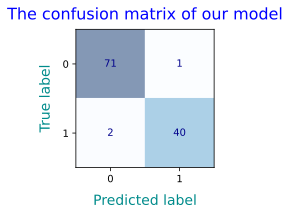

In [11]:
# creates a figure and a set of subplots. 'fig' represents the entire figure, while 'ax' represents a
# single subplot within that figure. The figsize=(2.5, 2.5) parameter specifies the size of the figure
# to be 2.5 inches by 2.5 inches when printed on a support with 100dpi (dots per inch).
fig, ax = plt.subplots(figsize=(2.5, 2.5))
plt.title("The confusion matrix of our model", fontsize=16, color='blue', pad=10)
# displays the confusion matrix using the 'matshow' function of the subplot 'ax'. 'confmat' is the
# NumPy array representing the confusion matrix defined in the previous cell. The 'cmap=plt.cm.Blues'
# argument sets the colormap to 'Blues', which will be used to color the matrix elements; 'Blues'
# consists of shades of blue ranging from light to dark, the higher the number the darker the 
# corresponding blue. The 'alpha=0.5' parameter sets the transparency level to 0.5, making the matrix
# moderately transparent, which helps distinguish the numbers (written in black) on the darker blue
# areas
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.5)
# this loop iterates over the rows of the 'confmat' array
for i in range(confmat.shape[0]):
    # this nested loop iterates over the columns of the 'confmat' array
    for j in range(confmat.shape[1]):
        # in Matplotlib 'x' (resp. 'y') corresponds to the columns (resp. rows). Moreover, the
        # 'va='center'' and 'ha='center'' arguments specify that the text should be vertically and
        # horizontally centered within each cell
        ax.text(y=i, x=j, s=confmat[i, j], va='center', ha='center', color='darkblue')
# Set x-axis' ticks positions to bottom only
ax.xaxis.set_ticks_position('bottom')
plt.xlabel("Predicted label", labelpad=10, fontsize=14, color='darkcyan')
plt.ylabel("True label", labelpad=10, fontsize=14, color='darkcyan')
plt.show()

<br><span style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
    Since our class $1$ corresponds to the malignant tumors (see cell $2$) and is the <font color='#cc33ff'>positive</font> class, our model correctly classified $71$ benign tumors (<font color='#1aabff'>$TN$</font>) and $40$ malignant tumors (<font color='#1aabff'>$TP$</font>). Moreover, it incorrectly misclassified $2$ malignant tumors as benign (<font color='#1aabff'>$FN$</font>), and $1$ benign tumor as malignant (<font color='#1aabff'>$FP$</font>).

<br><br><div style="font-family: Arial; font-size: 14px; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>5b. Accuracy, error, recall and precision of a classification model</font><a id="5b"></a></p>$\quad$
        In the binary classification tasks considered so far in this course, we did not need the extra precision that splitting false predictions between <font color='#cc33ff'>false negatives</font> and <font color='#cc33ff'>false positives</font> offers; we only cared about the correctness of the predictions. The ratio of correct predictions is called the <font color = darkpink>accuracy</font>. For example in this part, to estimate the quality of our predictors, we only asked for their accuracy. But sometimes, it makes sense to distinguish between both types of errors. For example, when predicting whether a cancer is benign or malignant (resp. <font color='#cc33ff'>negative</font> or <font color='#cc33ff'>positive</font>), <font color='#cc33ff'>false negatives</font> fail to recognize the treatment urgency, while <font color='#cc33ff'>false positives</font> worry the patient unnnecessarily.<br>$\quad$
        In order to deal with all possible binary classification tasks, we use various scoring methods. Using the notations of the previous subchapter, we define :<ul>
<li>The <font color='darkpink'>(prediction) accuracy (score)</font> is, as usual, the ratio of correct predictions :<div style="margin-top: 10px"></div><font color = darkpink>
        $$ACC \;=\; \frac{TN+TP}{TN+TP+FN+FP} \qquad\quad (1)$$</font></li>
<li>The <font color='darkpink'>(prediction) error</font> is the ratio of wrong predictions :<div style="margin-top: 10px"></div><font color = darkpink>
        $$ERR \;=\; \frac{FN+FP}{TN+TP+FN+FP} \;=\; 1-ACC \qquad\quad (2)$$</font><div style="margin-top: 10px"></div></li>
<li>The <font color='darkpink'>recall</font>, or <font color='darkpink'>true positive rate</font>, is the ratio of <font color='#cc33ff'>positives</font> that are correctly predicted :<div style="margin-top: 10px"></div><font color = darkpink>
        $$REC \;=\; TPR \;=\; \frac{TP}{TP+FN} \qquad\quad (3)$$</font><div style="margin-top: 10px"></div></li>
<li>The <font color='darkpink'>false positive rate</font> is the ratio of <font color='#cc33ff'>negatives</font> that are incorrectly predicted :<div style="margin-top: 10px"></div><font color = darkpink>
        $$FPR \;=\; \frac{FP}{TN+FP} \qquad\quad (4)$$</font><div style="margin-top: 10px"></div></li>
<li>The <font color='darkpink'>precision</font> is the ratio of true <font color='#cc33ff'>positives</font> among the <font color='#cc33ff'>positive</font> predictions :<div style="margin-top: 10px"></div><font color = darkpink>
        $$PRE \;=\; \frac{TP}{TP+FP} \qquad\quad (5)$$</font></li></ul>

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Thus optimizing the <font color='#cc33ff'>recall</font> is equivalent to trying to catch all the <font color='#cc33ff'>positives</font>. In our example of cancerous cells, this means to try and catch all the malignant tumors. This usually goes with an augmentation of the false <font color='#cc33ff'>positives</font>, ie a lesser precision. In our example, this means worrying more patients unnecessarily. To balance the pros and cons of optimizing <font color='#1aabff'>$PRE$</font> and <font color='#1aabff'>$REC$</font>, the harmonic mean of <font color='#1aabff'>$PRE$</font> and <font color='#1aabff'>$REC$</font> is used; it is called the <font color='darkpink'>$\,F1$ score</font> :<div style="margin-top: 10px"></div><font color='darkpink'>
        $$F1 \;=\; 2 \, \frac{REC \times PRE}{REC+PRE} \qquad\quad (6)$$</font><div style="margin-top: 10px"></div>$\quad$
        Harder to interpret than the <font color='#cc33ff'>$\,F1$ score</font>, but regarded as a superior metric, is the <font color='purple'>Matthews correlation coefficient</font> (<font color='purple'>MCC</font>) :<div style="margin-top: 10px"></div><font color = purple>
        $$MCC \;=\; \frac{TN \times TP \,-\, FN \times FP}{\sqrt{(TN+FP)(FN+TP)(TN+FN)(FP+TP)}} \qquad\quad (7)$$</font><div style="margin-top: 10px"></div><br>$\quad$
        These scoring metrics are all implemented in the <font color='#cc33ff'>sklearn.metrics</font> module of <font color='#cc33ff'>scikit-learn</font> :

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
print(BB + "The accuracy score over the test set is" + MB,
      round(accuracy_score(y_true=y_test, y_pred=y_pred), 3))
print(BB + "The recall score over the test set is" + MB,
      round(recall_score(y_true=y_test, y_pred=y_pred), 3))
print(BB + "The precision score over the test set is" + MB,
      round(precision_score(y_true=y_test, y_pred=y_pred), 3))
print(BB + "The F1 score over the test set is" + MB,
      round(f1_score(y_true=y_test, y_pred=y_pred), 3))
print(BB + "The MCC score over the test set is" + MB,
      round(matthews_corrcoef(y_true=y_test, y_pred=y_pred), 3))

The accuracy score over the test set is 0.974
The recall score over the test set is 0.952
The precision score over the test set is 0.976
The F1 score over the test set is 0.964
The MCC score over the test set is 0.943


<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        The <font color='#cc33ff'>sklearn.metrics</font> module contains a function, <font color='#cc33ff'>make_scorer</font>, which transforms any metric or loss function from the following list :<br>$\qquad$
        https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values </font><br>
into what is called a <font color='darkpink'>scorer</font>. With estimators and functions having a <font color='#cc33ff'>scoring</font> parameter, it is possible to use any of their <font color='#cc33ff'>scorers</font> instead of the default <font color='#cc33ff'>scoring</font> method. It is also possible to use one's own <font color='#cc33ff'>scorers</font>, that can be defined as explained below this list; we'll see an example of it in the second snippet.<div style="margin-top: 20px"></div>$\quad$
        Let's now copy our code in cell 7, but instead of selecting the best estimator according to the <font color='#cc33ff'>accuracy score</font>, we select the best estimator according to the <font color='#cc33ff'>$\,F1$ score</font> in the first snippet, and according to the <font color='#cc33ff'>recall score</font> in the second. The <font color='#cc33ff'>$\,F1$</font>-based <font color='#cc33ff'>classifier</font> is the same as the <font color='#cc33ff'>accuracy</font>-based <font color='#cc33ff'>classifier</font>, and yields better predictive results than the <font color='#cc33ff'>recall</font>-based <font color='#cc33ff'>classifier</font>, even in terms of <font color='#cc33ff'>recall_score</font> :

In [13]:
from sklearn.metrics import make_scorer

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']},
              {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}]
# pipe_svc is defined in cell 7
gsf1 = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring=make_scorer(f1_score), cv=10,
                  refit=True, n_jobs=-1)
clf = gsf1.fit(X_train, y_train).best_estimator_
print(BB + "The best estimator when using the F1 score is\n" + MB, clf)
print(BB + "The mean of its F1 scores over all the 10-folds is" + MB, gsf1.best_score_)
print(BB + "The best values for the tested hyperparameters are\n" + MB, gsf1.best_params_)

y_pred = clf.predict(X_test)
print(BB + "Its F1 score over the test set is" + MB, round(f1_score(y_test, y_pred), 3))
print(BB + "Its recall score over the test set is" + MB, round(recall_score(y_test, y_pred), 3))
print(BB + "Its precision score over the test set is" + MB, round(precision_score(y_test, y_pred), 3))

The best estimator when using the F1 score is
 Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=100.0, gamma=0.001, random_state=1))])
The mean of its F1 scores over all the 10-folds is 0.9785984848484848
The best values for the tested hyperparameters are
 {'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
Its F1 score over the test set is 0.964
Its recall score over the test set is 0.952
Its precision score over the test set is 0.976


In [14]:
# Custom scoring function with zero_division set to 0 (this function is not strictly necessary here, but it avoids
# Sagemaker Studio Lab writing tons of warnings; its goal is to tell what to do in case there would be a division
# by 0, ie in case there would be no positives; we could set 'zero_division=1', or whatever value we want, since
# there are positives). Moreover, it shows how to use 'make_scorer'
def custom_recall_score(y_true, y_pred):
    return recall_score(y_true, y_pred, zero_division=0)

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']},
              {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}]

gsp = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring=make_scorer(custom_recall_score),
                   cv=10, refit=True, n_jobs=-1)

# Fit the model and get the best estimator
clf = gsp.fit(X_train, y_train).best_estimator_

# Output the results
print(BB + "The best estimator when using the precision score is\n" + MB, clf)
print(BB + "The mean of its precision scores over all the 10-folds is" + MB, gsp.best_score_)
print(BB + "The best values for the tested hyperparameters are\n" + MB, gsp.best_params_)

y_pred = clf.predict(X_test)
print(BB + "\nIts recall score over the test set is" + MB, round(recall_score(y_test, y_pred), 3))
print(BB + "Its precision score over the test set is" + MB, round(precision_score(y_test, y_pred), 3))
print(BB + "Its F1 score over the test set is" + MB, round(f1_score(y_test, y_pred), 3))

The best estimator when using the precision score is
 Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=10.0, gamma=0.1, random_state=1))])
The mean of its precision scores over all the 10-folds is 0.9764705882352942
The best values for the tested hyperparameters are
 {'svc__C': 10.0, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}

Its recall score over the test set is 0.929
Its precision score over the test set is 0.886
Its F1 score over the test set is 0.907


<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Recall that the results we obtain on small datasets are highly dependent on the initial split between <font color='#1aabff'>X_train</font> and <font color='#1aabff'>X_test</font>, and therefore shouldn't be seen as benchmarks. Their real value lies in illustrating concepts and methods. In this case, the best estimator selected according to the <font color='#cc33ff'>$\,F1$ score</font> yields better predictive results than the one selected according to the <font color='#cc33ff'>recall score</font>, not just in terms of <font color='#cc33ff'>$\,F1$ score</font> and <font color='#cc33ff'>precision_score</font> (as expected), but also in terms of <font color='#cc33ff'>recall_score</font> itself, which is surprising. This suggests that <font color='#1aabff'>X_train</font> contains <font color='#cc33ff'>outliers</font> that mislead the <font color='#cc33ff'>recall</font>-based selection. More precisely, since <font color='#cc33ff'>recall</font> is the ratio of <font color='#cc33ff'>true positives</font> over all <font color='#cc33ff'>positives</font>, and since the total number of <font color='#cc33ff'>positives</font> in <font color='#1aabff'>X_train</font> doesn't depend on the <font color='#cc33ff'>classifier</font>, the estimator optimized for <font color='#cc33ff'>recall</font> tends to aggressively predict the <font color='#cc33ff'>positive</font> class to maximize its score. But this expansion of the <font color='#cc33ff'>decision region</font>, while effective on the training folds, turns out to be misaligned with the actual location of the <font color='#cc33ff'>positives</font> in the test set. On the contrary, the <font color='#cc33ff'>classifier</font> selected according to the <font color='#cc33ff'>$\,F1$ score</font>, which balances <font color='#1aabff'>$PRE$</font> and <font color='#1aabff'>$REC$</font> (as their harmonic mean), selects a region that contains more <font color='#cc33ff'>positives</font> of the test set. It is worth noting that the <font color='#cc33ff'>$\,F1$</font>-based estimator also outperforms the <font color='#cc33ff'>recall</font>-based <font color='#cc33ff'>classifier</font> on <font color='#cc33ff'>precision_score</font> (I invite the reader to verify this claim themselves). In this sense, <font color='#cc33ff'>$\,F1$ score</font> acts as a regularizer that mitigates the impact of outliers.

<br><br><div style="font-family: Arial; font-size: 14px; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>5c. The receiver operating characteristic (ROC)</font><a id="5c"></a></p>$\quad$
        In many classification algorithms, including <font color='#cc33ff'>logistic regression</font>, <font color='#cc33ff'>support vector machines</font>, and <font color='#cc33ff'>random forests</font> (all three presented in part 3), the model doesn't directly output class labels. Instead, it predicts probabilities that an <font color='#cc33ff'>instance</font> belongs to each <font color='#cc33ff'>class</font>.<br>$\quad$
        For <font color='#cc33ff'>binary classification</font> tasks, a <font color='darkpink'>decision threshold</font> is a value between $0$ and $1$ that is used to convert these probabilities into actual <font color='#cc33ff'>class</font> predictions : if the predicted probability of the <font color='#cc33ff'>positive class</font> (class $1$) is equal to or greater than the <font color='#cc33ff'>decision threshold</font>, then the <font color='#cc33ff'>instance</font> is classified as <font color='#cc33ff'>positive</font>; otherwise, it is classified as <font color='#cc33ff'>negative</font>.<br>$\quad$
        Note that the denominator of the <font color='#cc33ff'>recall</font>, <font color='#1aabff'>$\,(TP+FN)\,$</font>, is the total number of <font color='#cc33ff'>positive</font> instances, while the denominator of the <font color='#cc33ff'>false positive rate</font>, <font color='#1aabff'>$\,($TN$+FP)\,$</font>, is the total number of <font color='#cc33ff'>negative</font> instances, so these quantities do not depend on the value of the <font color='#cc33ff'>threshold</font>. Suppose that they are not zero - ie there are <font color='#cc33ff'>positive</font> and <font color='#cc33ff'>negative</font> instances -, so that the <font color='#cc33ff'>recall</font> <font color='#1aabff'>$REC$</font> and the <font color='#cc33ff'>false positive rate</font> <font color='#1aabff'>$FPR$</font> are defined. <font color='purple'>If the <font color='#cc33ff'>threshold</font> is $0$</font> then all instances will be predicted as <font color='#cc33ff'>positives</font>; hence <font color='#1aabff'>$TN$</font> and <font color='#1aabff'>$FN$</font> will be equal to $0$, so <font color='#1aabff'>$REC$</font> and <font color='#1aabff'>$FPR$</font> will be equal to $1$. Conversely, <font color='purple'>if the <font color='#cc33ff'>threshold</font> is equal to $1$</font> then all instances will be predicted as <font color='#cc33ff'>negatives</font>, <font color='#1aabff'>$TP$</font> and <font color='#1aabff'>$FP$</font> will be equal to $0$, and <font color='#1aabff'>$REC$</font> and <font color='#1aabff'>$FPR$</font> will be equal to $0$.<br>$\quad$
        Moreover when the <font color='#cc33ff'>threshold</font> goes from $0$ to $1$, only the numerators of the <font color='#1aabff'>$REC$</font> and of the <font color='#1aabff'>$FPR$</font> do change, and they decrease, so the <font color='#1aabff'>$REC$</font> and the <font color='#1aabff'>$FPR$</font> decrease; as we have just mentioned, they decrease from $1$ to $0$.<br><br>$\quad$
        For any <font color='#cc33ff'>threshold</font> $\,t\in[0,1]\,$ we can compute the corresponding <font color='#1aabff'>$FPR$</font> and <font color='#1aabff'>$REC$</font>, say <font color='#1aabff'>$\,xt\,$</font> and <font color='#1aabff'>$\,yt\,$</font>, and then place the point <font color='#1aabff'>$\,(xt,yt)\,$</font> on a diagram. The method is called the <font color='darkpink'>receiver operating characteristic</font> (<font color='darkpink'>ROC</font>); the curve is called the <font color='darkpink'>ROC curve</font>.<br>$\quad$
        If we follow the <font color='#cc33ff'>ROC curve</font> in ascending order of the <font color='#1aabff'>$FPR$</font> from $0$ to $1$, the corresponding <font color='#cc33ff'>thresholds</font> decrease from $1$ to $0$, and thus the <font color='#1aabff'>$REC$</font> increases from $0$ to $1$. Hence <font color='darkpink'>the ROC of any <font color='#cc33ff'>classifier</font> corresponds to an increasing function which goes from $(0,0)$ to $(1,1)$</font>.<br>$\quad$
        Note that if the predictions were made "perfectly" randomly (ie according to an equally distributed law over a near infinite set), then each instance would be classified as a $0$ or a $1$ such that in total if the <font color='#cc33ff'>decision threshold</font> is <font color='#1aabff'>$t$</font> then the proportion of instances that would be predicted as <font color='#cc33ff'>negative</font> would be <font color='#1aabff'>$t$</font>. If <font color='#1aabff'>$P$</font> is the number of <font color='#cc33ff'>positive instances</font>, then <font color='#1aabff'>$\,tP\,$</font> of them would be predicted as <font color='#cc33ff'>negatives</font> and <font color='#1aabff'>$\,(1\!-\!t)P\,$</font> would be predicted as <font color='#cc33ff'>positives</font>; consequently the number of <font color='#cc33ff'>true positives</font> would be <font color='#1aabff'>$\,TP=(1\!-\!t)P\,$</font>, so the <font color='#cc33ff'>recall</font> would be <font color='#1aabff'>$\,REC=1-t\,$</font>. And if <font color='#1aabff'>$N$</font> is the number of <font color='#cc33ff'>negative</font> instances, then <font color='#1aabff'>$\,tN\,$</font> would be <font color='#cc33ff'>true negatives</font> and <font color='#1aabff'>$\,(1\!-\!t)N\,$</font> would be <font color='#cc33ff'>false positives;</font> so the <font color='#cc33ff'>false positive rate</font> would be <font color='#1aabff'>$\,FPR=1-t\,$</font>. Hence <font color='magenta'>if the predictions are made "perfectly" randomly, then</font>, for any <font color='#cc33ff'>threshold</font> <font color='#1aabff'>$t$</font>, <font color='#1aabff'>$REC$</font> and <font color='#1aabff'>$FPR$</font> would be equal, to <font color='#1aabff'>$1\!-\!t$</font>; so in this case <font color='magenta'>the ROC curve is the linear curve $\,y=x\,$</font>.<br>$\quad$
        Any decent predictive model satisfies <font color='#1aabff'>$\,REC > FPR\,$</font> (ie the ratio of correctly predicted <font color='#cc33ff'>positives</font> is greater than the ratio of incorrectly predicted <font color='#cc33ff'>negatives</font>) for at least one <font color='#cc33ff'>threshold</font> $t_0$ (the one it uses for making its predictions). This corresponds to a point that is above the line <font color='#1aabff'>$\,y=x\,$</font>.<br>
    Some models may satisfy <font color='#1aabff'>$\,REC \geq FPR\,$</font> at some <font color='#cc33ff'>thresholds</font> and not satisfy this inequality at other <font color='#cc33ff'>thresholds</font>. For such models, the <font color='#cc33ff'>thresholds</font> corresponding to the part of the <font color='#cc33ff'>ROC curve</font> which is under the line <font color='#1aabff'>$\,y=x\,$</font> (ie <font color='#1aabff'>$\,REC<FPR\,$</font>) may be discarded, since they correspond to predictions that are worse than random guessing.<br>$\quad$
        Note also that a perfect <font color='#cc33ff'>classifier</font> would have a <font color='#cc33ff'>recall</font> of $1$ (ie $0$ <font color='#cc33ff'>false negatives</font>) and a <font color='#cc33ff'>false positive rate</font> of $0$ (ie $0$ <font color='#cc33ff'>false positives</font>) at a given <font color='#cc33ff'>threshold</font> <font color='#1aabff'>$t$</font>, corresponding to a point <font color='#1aabff'>$\,(xt,yt)=(0,1)\,$</font>. Then if we continuously decrease the <font color='#cc33ff'>threshold</font> less elements will be predicted as <font color='#cc33ff'>negatives</font>, so the <font color='#cc33ff'>recall</font> will remain $1$ while the <font color='#cc33ff'>false positive rate</font> will increase, up to $1$ (when the <font color='#cc33ff'>threshold</font> is $0$ or earlier); hence <font color='magenta'>the ROC curve of a perfect classifier is the vertical line from $(0,0)$ to $(0,1)$ followed by the horizontal line from $(0,1)$ to $(1,1)$</font>.<br><br>$\quad$
        Often associated with the <font color='#cc33ff'>ROC curve</font> is the <font color='darkpink'>ROC area under the curve</font> (<font color='darkpink'>ROC AUC</font>), which is the value of the surface area under the <font color='#cc33ff'>ROC curve</font>.<br>
    A random guessing will have a <font color='#cc33ff'>ROC AUC</font> of $0.5$, while a perfect <font color='#cc33ff'>classifier</font> will have a <font color='#cc33ff'>ROC AUC</font> of $1$. We can compare the <font color='#cc33ff'>ROC AUC</font> of an estimator to these numbers to get an idea of its quality across different <font color='#cc33ff'>threshold</font> values; or compare the quality of two estimators using their respective <font color='#cc33ff'>ROC AUC</font>, a higher <font color='#cc33ff'>ROC AUC</font> generally indicating a better discrimination ability of the model.<br><br>$\quad$
        The <font color='#cc33ff'>ROC curve</font> and the <font color='#cc33ff'>ROC AUC</font> are implemented in the <font color='#cc33ff'>sklearn.metrics</font> module of <font color='#cc33ff'>scikit-learn</font> under the names <font color='#cc33ff'>roc_curve</font> and <font color='#cc33ff'>roc_auc_score</font> respectively. We will use them now for a <font color='#cc33ff'>logistic regression pipeline</font> aimed at classifying the tumors of the <font color='#cc33ff'>Breast Cancer Wisconsin dataset</font>. We make its task more challenging by using only two features, so that the resulting <font color='#cc33ff'>ROC curve</font> becomes visually more interesting. For similar reasons, we only use <font color='#cc33ff'>stratified $k$-fold cross-validation</font> with $\,k=3\,$ (see "2. k-fold cross validation").<br><br>$\quad$
        <p style="margin: 0 0 0 2rem; font-size: 15px; font-weight: 600"><font color='purple'>$\quad$Notes :</font></p><ul>
<li>The code provided in the book does not use the <font color='#cc33ff'>roc_auc_score</font> but a more general <font color='#cc33ff'>scikit-learn</font> function called <font color='#cc33ff'>auc</font> which computes the area under the curve using the trapezoidal rule. I prefer to try the specific <font color='#cc33ff'>roc_auc_score</font>, so I asked ChatGPT to make the necessary changes. The results are exactly identical</li>
<li>The pipeline used in the book contains a <font color='#cc33ff'>PCA(n_components=2)</font> (see "Dimensionality reduction", "1b. Understanding Principal Component Analysis") as its second step, which would project the <font color='#cc33ff'>training set</font> features to the best $2$-dimensional space possible but then it reduces the <font color='#cc33ff'>training set</font> to its $2$ features number $4$ and $14$, so the PCA plays no role whatsoever. Therefore, I present two snippets : in the first I reduce the feature space to the features $4$ and $14$, and removed the PCA (so the results are still identical to those of the book); and in the second, I reduce the features space to the 2D-space obtained via <font color='#cc33ff'>PCA(n_components=2)</font>. As expected, the predictive results are much better in this second case.</li></ul>

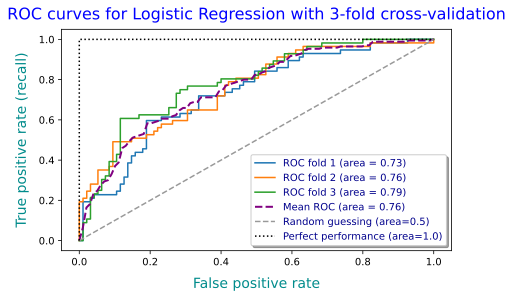

In [15]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold
# the interp function is used for linear interpolation, which is helpful in smoothing curves like the
# ROC curve
from numpy import interp

# creates a pipeline 'pipe_lr' that consists of two components: StandardScaler(), which standardizes
# the features by removing the mean and scaling to unit variance; and then we can use the 
# LogisticRegression with some parameters as the classifier
pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty='l2', random_state=1, solver='lbfgs', C=100.0))
# only keeps features number 4 and 14 of the initial set of features
X_train2 = X_train[:, [4, 14]]
# 'StratifiedKFold(n_splits=3)' does one single split of X_train2 into 3 disjoint subsets (folds),
# preserving the class distribution
# then 'split(X_train, y_train)' iterates over these folds, each time selecting a different fold as
# a validation set and the other two as the training set; the training set is written first
# at last, 'list(...)' just stores the results in a list for later use
cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))

fig = plt.figure(figsize=(7, 4))
plt.title("ROC curves for Logistic Regression with 3-fold cross-validation", fontsize=16, color='blue', pad=10)
# initializes the mean true positive rate to 0.0; this variable will be used to accumulate the true
# positive rates across different folds
mean_tpr = 0.0
# creates an array of 100 evenly spaced values between 0 and 1, both included, representing the false
# positive rates. This array will be used as the x-axis values for plotting the ROC curve.
mean_fpr = np.linspace(0, 1, 100)
# loops over the three partitions (rows) of 'cv'
for i, (train, test) in enumerate(cv):
    # fits the pipeline 'pipe_lr' to the training data for the current fold (X_train2[train]) and then
    # predicts probabilities for the test data (X_train2[test]); thus each row of 'probas' is composed
    # of 2 numbers, the probability that the corresponding row of X_train2[test] belongs to class 0,
    # and the probability that it belongs to class 1
    probas = pipe_lr.fit(X_train2[train], y_train[train]).predict_proba(X_train2[test])
    # scikit-learn decides based on probas[:, 1] on a list of thresholds, which are here returned in
    # the 'thresholds' variable; for each threshold it computes the corresponding false positive rate
    # and true positive rate according to the list of true classes (y_train[test]) and the list of the
    # probabilities predicted for X_train2[test] (probas[:, 1]) - if the threshold is less than
    # proba[n,1] then the n-th test instance will be predicted as positive, and a comparison with
    # y_train[test[n]] will tell if the prediction is true or false; the ratio of false positives will
    # be stored in 'fpr' and the ratio of true positives will be stored in 'tpr' -; in the end 'fpr'
    # and 'tpr' are lists of the same length than 'thresholds' and contain the ratios of false and
    # true positives for the various thresholds.
    # Note that the thresholds are arranged in decreasing order
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:, 1])
    # in order to draw (an approximation of) the ROC curve we defined a set of 100 abscissae equally
    # distributed from 0 to 1 (via mean_fpr = np.linspace(0, 1, 100)); now for each abscissa x we want
    # to find the point of the ROC whose abscissa is x, ie the point whose ordinate y is the TPR
    # corresponding to the threshold such that the associated FPR would be x. Instead of trying to
    # find this threshold we find in the 'fpr' list the two nearest values x1 and x2 such that
    # x1 <= x <= x2; thanks to the previous line of the code we know the TPR at these abscissae : they
    # are the values in the 'tpr' list with the same index than x1 and x2 in 'fpr' respectively, and
    # we use these values to get an approximation of y using the linear interpolation
    # y = y1 + [(y2-y1)/(x2-x1)](x-x1)
    # we add the interpolated values obtained for each partition and later we will divide these sums by 
    # the number of partitions in 'cv' (ie 3 here); thus for each abscissa (FPR) the ordinate (TPR) used
    # will be the mean of these interpolated values
    # note that we ask to make an interpolation for each value of mean_fpr, including 0 and 1; but for
    # 0 and 1 we already know the exact values of the associated TPR, which are 0 and 1 respectively,
    # so below we will reset 'mean_tpr[0] = 0.0' and 'mean_tpr[-1] = 1.0'
    mean_tpr += interp(mean_fpr, fpr, tpr)
    # scikit-learn computes the ROC AUC (for the current fold) using the trapezoidal rule
    roc_auc = roc_auc_score(y_train[test], probas[:, 1])
    # plots the ROC curve for the current fold using FPR on the x-axis and TPR on the y-axis
    # f'ROC fold {i+1} (area = {roc_auc:.2f})' is using Python's f-string formatting to create a
    # string with formatted values. The curly braces {} denote a placeholder for the variable to be
    # inserted; eg {i+1} will be replaced with the value of 'i+1' where 'i' is the fold number, while
    # {roc_auc:.2f} will be replaced with the value of round(roc_auc, 2) (and is the same as
    # {round(roc_auc, 2)})
    plt.plot(fpr, tpr, label=f'ROC fold {i+1} (area = {roc_auc:.2f})')

# divides each value in the mean_tpr array by the number of partitions len(cv). This step is performed
# to calculate the mean of the approximated values of the true positive rate (TPR) obtained for each
# fold in the above loop
mean_tpr /= len(cv)
# we know that the ROC curve starts at (0,0), so we reset the first value of mean_tpr
mean_tpr[0] = 0.0
# we know that the ROC curve ends at (1,1), so we reset the last value of mean_tpr
mean_tpr[-1] = 1.0
# uses the 'roc_auc_score' function from scikit-learn to calculate the ROC AUC based on the true
# labels 'y_train' and the probabilities predicted by our pipeline 'pipe_lr'
mean_auc = roc_auc_score(y_train, pipe_lr.fit(X_train2, y_train).predict_proba(X_train2)[:, 1])
# plots the mean ROC curve using the mean false positive rates 'mean_fpr' and mean true positive rates
# 'mean_tpr'. The curve is dashed ('--'), the width of the line is 2 and its color is purple; a label
# is added, indicating "Mean ROC" and its AUC 'mean_auc' rounded to two decimal places
plt.plot(mean_fpr, mean_tpr, '--', lw=2, color='purple', label=f'Mean ROC (area = {mean_auc:.2f})')

# plots a dashed line from (0, 0) to (1, 1) with a gray color (0.6, 0.6, 0.6) representing random
# guessing; a label is added for reference
plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='Random guessing (area=0.5)')
# plots a dotted line joining (0,0) to (0,1) and then (0,1) to (1,1) with a black color representing
# the ROC of a perfect classifier; a label is added for reference
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='black', label='Perfect performance (area=1.0)')
# sets the limits of the x-axis for the plot, from -0.05 to 1.05
plt.xlim([-0.05, 1.05])
# sets the limits of the y-axis for the plot, from -0.05 to 1.05
plt.ylim([-0.05, 1.05])
plt.xlabel("False positive rate", labelpad=10, fontsize = 14, color='darkcyan')
plt.ylabel("True positive rate (recall)", labelpad=10, fontsize = 14, color='darkcyan')
plt.legend(loc='lower right', fancybox=True, shadow=True, fontsize=10, labelcolor='darkblue')
plt.show()

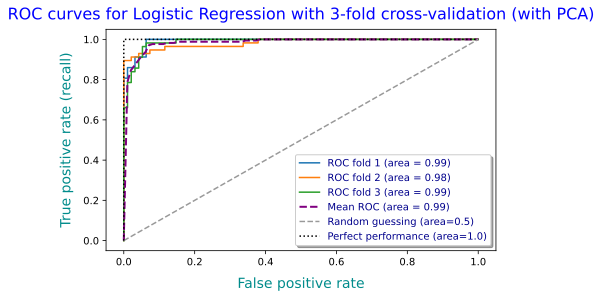

In [16]:
# This code is identical to the previous one, except that I do not reduce the set of all initial
# features to the arbitrary features number 4 and 14, but instead use a PCA(n_components=2) as the
# second step of the pipeline
pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=2),
                        LogisticRegression(penalty='l2', C=100.0, solver='lbfgs', random_state=1))
X_train1 = X_train
cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))

fig = plt.figure(figsize=(7, 4))
plt.title("ROC curves for Logistic Regression with 3-fold cross-validation (with PCA)", fontsize=16, color='blue', pad=10)
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train1[train], y_train[train]).predict_proba(X_train1[test])
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    roc_auc = roc_auc_score(y_train[test], probas[:, 1])
    plt.plot(fpr, tpr, label=f'ROC fold {i+1} (area = {roc_auc:.2f})')

mean_tpr /= len(cv)
mean_tpr[0] = 0.0
mean_tpr[-1] = 1.0
mean_auc = roc_auc_score(y_train, pipe_lr.fit(X_train1, y_train).predict_proba(X_train1)[:, 1])
plt.plot(mean_fpr, mean_tpr, '--', lw=2, color='purple', label=f'Mean ROC (area = {mean_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='Random guessing (area=0.5)')
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='black', label='Perfect performance (area=1.0)')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel("False positive rate", labelpad=10, fontsize = 14, color='darkcyan')
plt.ylabel("True positive rate (recall)", labelpad=10, fontsize = 14, color='darkcyan')
plt.legend(loc='lower right', fancybox=True, shadow=True, fontsize=10, labelcolor='darkblue')
plt.show()

<br><br><div style="font-family: Arial; font-size: 14px; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>5d. Scoring metrics for multiclass classification</font><a id="5d"></a></p>$\quad$
        The scoring metrics that we’ve discussed so far are specific to binary classification systems. However, <font color='#cc33ff'>scikit-learn</font> also implements macro and micro averaging methods to extend those scoring metrics to multiclass problems via One versus the Rest (OvR) classification (presented in part 3, "1a. Multi-label classification with OvR"). The <font color='darkpink'>micro-average</font> is calculated from the individual <font color='#1aabff'>$TP$</font>s, <font color='#1aabff'>$FN$</font>s, <font color='#1aabff'>$TN$</font>s, and <font color='#1aabff'>$FP$</font>s of the system. For example, the <font color='#cc33ff'>micro-average</font> of the precision score in a <font color='#1aabff'>$K$</font>-class system is defined by :<div style="margin-top: 10px"></div><font color = darkpink>
        $$PRE_{micro} \;=\; \frac{\sum_{k=0}^{K-1}\,TP_k}{\sum_{k=0}^{K-1}\,TP_k \,+\, \sum_{k=0}^{K-1}\,FP_k} \qquad\quad (8)$$</font><div style="margin-top: 10px"></div>$\quad$
        The <font color='darkpink'>macro-average</font> is simply defined as the average scores of the different binary classification systems (one per class). For example, the <font color='#cc33ff'>macro-average</font> of the precision score in a <font color='#1aabff'>$K$</font>-class system is :<div style="margin-top: 10px"></div><font color = darkpink>
        $$PRE_{macro} \;=\; \frac{\sum_{k=0}^{K-1}\,PRE_k}{K} \qquad\quad (9)$$</font><div style="margin-top: 10px"></div>
    where <font color='#1aabff'>$PRE_k$</font> is the precision for the class <font color='#1aabff'>$k$</font>, ie <font color='#1aabff'>$PRE_k \;=\; \frac{TP_k}{TP_k + FP_k}$</font>.<div style="margin-top: 20px"></div>$\quad$
        Micro-averaging is useful if we want to weight each instance or prediction equally, whereas macro-averaging weighs all classes equally.<br>$\quad$
        In <font color='#cc33ff'>scikit-learn</font> the default is the <font color='darkpink'>weighted (macro-) average</font> :<div style="margin-top: 10px"></div><font color = darkpink>
        $$PRE_{w-macro} \;=\; \frac{\sum_{k=0}^{K-1}\; m_k \, PRE_i}{m} \qquad\quad (10)$$</font><div style="margin-top: 10px"></div>
    where <font color='#1aabff'>$m_k$</font> is the number of instances in class <font color='#1aabff'>$k$</font>, and <font color='#1aabff'>$m$</font> is the total number of instances.

<a id="Appendix"></a><br><br><br><div style="font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">
    <h4 style="margin: 0 0 .5rem 2rem; font-size: 18px; font-weight: 800"><font color='darkpink'>APPENDIX - DEALING WITH CLASS IMBALANCE</font></h4>$\quad$
        We say that a dataset has a <font color='darkpink'>class imbalance</font> iff one class or multiple classes are over-represented. We can think of several domains where this may occur, such as spam filtering, fraud detection, or screening for diseases.<br>$\quad$
        If a class represents $90\%$ of a dataset, then simply predicting that any instance is in this class will get a $90\%$ accuracy; so getting a $90\%$ accuracy would mean that our model hasn’t learned anything useful from the features provided in this dataset. Thus, when we fit <font color='#cc33ff'>classifiers</font> on imbalanced datasets, it would make sense to use other metrics than accuracy when comparing different models, such as precision (see "5b. Accuracy, error, recall and precision of a classification model"), <font color='#cc33ff'>recall</font> (idem), the <font color='#cc33ff'>ROC curve</font> (see "5c. The receiver operating characteristic (ROC)"), whatever we care most about in our application. For instance, our priority might be to identify the majority of patients with malignant cancer to recommend an additional screening, in which case <font color='#cc33ff'>recall</font> should be our metric of choice; or, in spam filtering, where we don’t want to label emails as spam if the system is not very certain, precision might be a more appropriate metric.<br><p style="margin: 0 0 .5rem 0"></p>$\quad$
        Aside from metrics for evaluating machine learning models, class imbalance influences a learning algorithm during model fitting itself. Since machine learning algorithms typically optimize a reward or loss function that is computed as a sum over the training examples that it sees during fitting, the decision rule is likely going to be biased toward the majority class. Therefore, either we assign a larger penalty to wrong predictions on the minority class, or we upsample the minority class, or we downsample the majority class. To <font color='darkpink'>upsample</font> the minority class means to add copies of instances of the minority class, typically randomly chosen with replacement, until it contains the same number of instances than the majority class; while to <font color='darkpink'>downsample</font> the majority class means to randomly remove instances from the majority class until it contains the same number of instances than the minority class.<br>$\quad$
        In <font color='#cc33ff'>scikit-learn</font>, adjusting penalties to alleviate biases towards the most represented classes is done by setting the <font color='#cc33ff'>class_weight</font> parameter, which is implemented for most <font color='#cc33ff'>classifiers</font>, to <font color='#cc33ff'>class_weight='balanced'</font>.<br>$\quad$
        While both <font color='#cc33ff'>upsampling</font> and <font color='#cc33ff'>downsampling</font> are done using the <font color='#cc33ff'>resample(arrays, replace=True, n_samples=None)</font> function from the <font color='#cc33ff'>sklearn.utils</font> module of <font color='#cc33ff'>scikit-learn</font> :<ul>
    <li> <font color='#cc33ff'>arrays</font> is a set of at least one array (or list) to <font color='#cc33ff'>upsample</font> or <font color='#cc33ff'>downsample</font></li>
    <li> <font color='#cc33ff'>replace=True</font> means that any <font color='#cc33ff'>upsampling</font> will be done with replacement</li>
    <li> and <font color='#cc33ff'>n_samples</font> is the desired length for all the arrays; its default value is <font color='#cc33ff'>None</font>, in which case all arrays will end up with the same number of elements as the largest array provided</li></ul>$\quad$
        Let's see this last technique on an example, in which we first remove some instances of class $1$ from our <font color='#cc33ff'>Breast Cancer Wisconsin dataset</font>, which originally consisted of $357$ benign tumors (class $0$) and $212$ malignant tumors (class $1$), to make it more imbalanced; the new set is called <font color='#5555ff'>X_imb</font>, and the set of corresponding classes is called <font color='#5555ff'>y_imb</font> :

In [17]:
X_imb = np.vstack((X[y == 0], X[y == 1][:40]))
y_imb = np.hstack((y[y == 0], y[y == 1][:40]))

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        <font color='#5555ff'>X_imb</font> contains approximately only $10\%$ of instances of class $1$ ($40$ out of $397$). And now we upsample the class $1$ : 

In [18]:
from sklearn.utils import resample
print(BB + "The initial number of instances of class 1 is :" + MB, X_imb[y_imb == 1].shape[0])

X_upsampled, y_upsampled = resample(X_imb[y_imb == 1], y_imb[y_imb == 1], replace=True,
                                    n_samples=X_imb[y_imb == 0].shape[0], random_state=123)

print(BB + "The final number of instances of class 1 is :" + MB, X_upsampled[y_upsampled == 1].shape[0])

The initial number of instances of class 1 is : 40
The final number of instances of class 1 is : 357


<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
    After <font color='#cc33ff'>resampling</font>, we can stack the original class $0$ samples with the <font color='#cc33ff'>upsampled class</font> $1$ instances to obtain a balanced dataset <font color='#5555ff'>X_bal</font> :

In [19]:
X_bal = np.vstack((X_imb[y_imb == 0], X_upsampled))
y_bal = np.hstack((y_imb[y_imb == 0], y_upsampled))

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
    We can check that our new set of instances <font color='#5555ff'>X_bal</font> contains $357$ instances of class $0$ and $357$ instances of class $1$:

In [20]:
print(BB + "In our new set of instances X_bal, the number of instances of class 0 is :" + MB,
      X_bal[y_bal == 0].shape[0])
print(BB + "In our new set of instances X_bal, the number of instances of class 1 is :" + MB,
      X_bal[y_bal == 1].shape[0])

In our new set of instances X_bal, the number of instances of class 0 is : 357
In our new set of instances X_bal, the number of instances of class 1 is : 357
